In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter


In [2]:
sys.path.insert(0, '/kaggle/input/visionmam/') 

In [4]:
# !pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [5]:
# !pip install mamba_ssm 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323594419 sha256=14afe4f1bb9d9dcf51ae45091b05c585b97395058df5d216a47c1794c4630223
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba_ssm


In [6]:
from VisionMamba import VSSM as medmamba # import model

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [8]:
import torchvision.models as models
from torchvision import transforms

In [9]:
import matplotlib.pyplot as plt

In [10]:
import cv2

In [11]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.0 MB/s eta 0:00:0000:0100:01


In [12]:
!pip install torch torchvision timm

In [13]:
import timm

In [14]:
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
file1 = '/kaggle/input/cigar-4/train1.csv' #1350
df1 = pd.read_csv(file1,encoding='utf-8',skiprows=-1) 
df1_data = df1.drop(df1.columns[1555:1558], axis=1)
df1_data_0 = df1_data.to_numpy(dtype ='float32')
df1_label = df1['lable']
df1_label_0 = df1_label.to_numpy(dtype ='int64')

file2 = '/kaggle/input/cigar-4/test.csv' #1350
df1 = pd.read_csv(file2,encoding='utf-8',skiprows=-1) 
df1_data = df1.drop(df1.columns[1555:1558], axis=1)
df1_data_1 = df1_data.to_numpy(dtype ='float32')
df1_label = df1['lable']
df1_label_1 = df1_label.to_numpy(dtype ='int64')

In [17]:
df1_data_0.shape

(1680, 1555)

In [18]:
df1_data_1.shape

(156, 1555)

In [18]:
# # 复制矩阵并添加高斯噪声
# noise = np.random.normal(0.1, 0.09, (424, df1_data_0.shape[1]))
# noisy_matrix = df1_data_0[:424,:] + noise
# # 将原始矩阵和带噪声的矩阵拼接在一起
# df1_data_00 = np.concatenate((df1_data_0, noisy_matrix), axis=0)

In [ ]:
# # 复制一份原始标签
# copied_labels = np.copy(df1_label_0[:424])
# # 使用numpy的concatenate函数将两个标签拼接在一起
# df1_label_00 = np.concatenate((df1_label_0, copied_labels))

In [ ]:
# df1_label_00.shape,df1_data_00.shape

In [ ]:
# # 复制一份原始标签
# copied_labels = np.copy(df1_org_train)
# # 使用numpy的concatenate函数将两个标签拼接在一起
# df1_org_train0 = np.concatenate((df1_org_train, copied_labels))

In [ ]:
# # 复制一份原始标签
# copied_labels = np.copy(df1_year_train)
# # 使用numpy的concatenate函数将两个标签拼接在一起
# df1_year_train0 = np.concatenate((df1_year_train, copied_labels))

In [19]:
train_datas = df1_data_0
val_datas =  df1_data_1
train_labels = df1_label_0
val_labels = df1_label_1

In [ ]:
# train_datas.shape,val_datas.shape

In [ ]:
# train_datas, val_datas, train_labels, val_labels = train_test_split(df1_data_0[:,:],df1_label_0[:], test_size=0.3, random_state=98,shuffle = True)

In [20]:
train_datas.shape,val_datas.shape

((1680, 1555), (156, 1555))

Pre-process

In [21]:
def snv(input_data):
    # Calculate the mean and standard deviation for each spectrum
    mean = np.mean(input_data, axis=1, keepdims=True)
    std_dev = np.std(input_data, axis=1, keepdims=True)
    # Apply SNV
    snv_data = (input_data - mean) / std_dev
    return snv_data

from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline

def baseline_correction(input_data):
    baseline_corrected_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        peaks, _ = find_peaks(-input_data[i])
        spline = UnivariateSpline(peaks, input_data[i][peaks], s=0, k=2)
        baseline = spline(range(len(input_data[i])))
        baseline_corrected_data[i] = input_data[i] - baseline
    return baseline_corrected_data

def msc(input_data):
    mean_spectrum = np.mean(input_data, axis=0)
    corrected_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        fit = np.polyfit(mean_spectrum, input_data[i], 1, full=True)
        corrected_data[i] = (input_data[i] - fit[0][1]) / fit[0][0]
    return corrected_data

from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
def first_derivative(input_data, window_size=5, poly_order=2):
    derivative_data = savgol_filter(input_data, window_length=window_size, polyorder=poly_order, deriv=1)
    return derivative_data

# 一阶导数
def D1(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after First derivative :(n_samples, n_features)
    """
    n, p = data.shape
    Di = np.ones((n, p - 1))
    for i in range(n):
        Di[i] = np.diff(data[i])
    return Di


# 二阶导数
def D2(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after second derivative :(n_samples, n_features)
    """
    data = deepcopy(data)
    if isinstance(data, pd.DataFrame):
        data = data.values
    temp2 = (pd.DataFrame(data)).diff(axis=1)
    temp3 = np.delete(temp2.values, 0, axis=1)
    temp4 = (pd.DataFrame(temp3)).diff(axis=1)
    spec_D2 = np.delete(temp4.values, 0, axis=1)
    return spec_D2

In [22]:

# X = train_datas
# X = snv(X)
# X = msc(X)
# X = D1(X)
# X = baseline_correction(X)
# train_data = savgol_filter(X[:,:], 51, 3)



# X = val_datas
# X = snv(X)
# X = msc(X)
# X = D1(X)
# X = baseline_correction(X)
# test_data = savgol_filter(X[:,:], 51, 3)

scaler = StandardScaler()
X = train_datas
X = scaler.fit_transform(X)
X = first_derivative(X)
X = snv(X)
train_data = savgol_filter(X[:,:], 49, 3)

X = val_datas
X = scaler.fit_transform(X)
X = first_derivative(X)
X = snv(X)
test_data = savgol_filter(X[:,:], 49, 3)

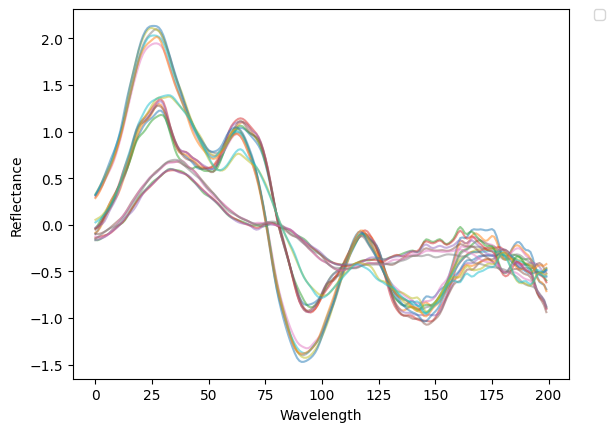

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(test_data[:20,1000:1200].T,  alpha=0.5)
plt.xlabel("Wavelength")
plt.ylabel("Reflectance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Create model

In [24]:
# 定义GetLoader类，继承Dataset方法，并重写__getitem__()和__len__()方法
class GetLoader(torch.utils.data.Dataset):
	# 初始化函数，得到数据
    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label
    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        data = self.data[index]
        labels = self.label[index]
        return data, labels
    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self):
        return len(self.data)

In [25]:
# 创建数据加载器
# 创建数据加载器
train_dataset = GetLoader(train_data[:,1000:1200], train_labels)
test_dataset = GetLoader(test_data[:,1000:1200], val_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

In [26]:
# 定义注意力机制模块
class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.conv = nn.Conv1d(in_channels, 1, kernel_size=1)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        attention_weights = self.conv(x)
        attention_weights = self.softmax(attention_weights)
        x = x * attention_weights
        return x
    
# 定义近红外光谱数据处理部分
class SpectrumModel(nn.Module):
    def __init__(self, input_shape):
        super(SpectrumModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(256)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(32)
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(3040, 128) #32x15744 and 15872x128  #5504
        self.atten1 = Attention(16)
        
    def forward(self, x):
        x = x.float()
        x = torch.tensor(x).unsqueeze(1).expand(-1, 1, -1)
        
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        x = self.bn4(self.conv4(x))
        x = self.bn5(self.conv5(x))
        x = self.atten1(x)        
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    
    
# 载入预训练的MobileNet模型，并将其参数冻结（不进行训练）
def load_frozen_mobilenet():
#     mobilenet = models.mobilenet_v3_large(pretrained=True)
    mobilenet = timm.create_model('vit_base_patch16_224', pretrained=True)
    for param in mobilenet.parameters():
        param.requires_grad = False
    return mobilenet
 
# 创建一个新的分类器，在MobileNet的基础上
class MobileNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(MobileNetFeatureExtractor, self).__init__()
        self.mobilenet = load_frozen_mobilenet()
        self.classifier = nn.Linear(1000, 128)  # 假设MobileNet的最后一层是1024维
 
    def forward(self, x):
        x = self.mobilenet(x)  # 提取特征
        x = self.classifier(x)  # 进行分类
        return x    
    
# 载入预训练的MobileNet模型，并将其参数冻结（不进行训练）
def load_frozen_vit():
    mobilenet = timm.create_model('twins_pcpvt_small', pretrained=True)
    for param in mobilenet.parameters():
        param.requires_grad = False
    return mobilenet
 
# 创建一个新的分类器，在MobileNet的基础上
class VitFeatureExtractor(nn.Module):
    def __init__(self):
        super(VitFeatureExtractor, self).__init__()
        self.mobilenet = load_frozen_vit()
        self.classifier = nn.Linear(1000, 128)  # 假设MobileNet的最后一层是1024维
 
    def forward(self, x):
        x = self.mobilenet(x)  # 提取特征
        x = self.classifier(x)  # 进行分类
        return x    
# 定义格拉姆矩阵处理部分
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(kernel_size=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(64, 80, kernel_size=3, padding=1)
        self.avgpool4 = nn.AvgPool2d(kernel_size=2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.conv5 = nn.Conv2d(80, 104, kernel_size=5, padding=2)
        
        self.fc1 = nn.Linear(20384, 128)  # 修改尺寸 14976 3744


    def forward(self, x):
        x = x.float()
        x = F.relu(self.conv1(x))
        
        a = F.relu(self.avgpool1(x))
        m = F.relu(self.maxpool1(x))
        x = a#torch.cat((a, m), 1)
        
        x = F.relu(self.conv2(x))
        
        a = F.relu(self.avgpool2(x))
        m = F.relu(self.maxpool2(x))
        x = a#torch.cat((a, m), 1)
        
        x = F.relu(self.conv3(x))
        
        a = F.relu(self.avgpool3(x))
        m = F.relu(self.maxpool3(x))
        x = a#torch.cat((a, m), 1)
        
        x = F.relu(self.conv4(x))
        
        a = F.relu(self.avgpool4(x))
        m = F.relu(self.maxpool4(x))
        x = a#torch.cat((a, m), 1)
        
        x = F.relu(self.conv5(x))
        
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        
        return x

gasf = GramianAngularField(method='difference')   
gadf = GramianAngularField(method='summation')
mtf = MarkovTransitionField() 
def convert_to_3_channels(image):
    return np.stack((image, image, image), axis=-1)
def generate_gram_matrix(spectrum_data):

        X_gasf = gasf.transform(spectrum_data.cpu())
   
        resized_images = []
        for image in X_gasf:
            # 将图像从二维数组转换为三维数组，并添加一个通道维度
            image = np.expand_dims(image, axis=-1)
            # 调整图像大小为(224, 224)
            resized_image = cv2.resize(image, (224, 224))
            resized_images.append(resized_image)

            # 将调整后的图像转换为NumPy数组
        resized_images = np.array(resized_images)
        three_channel_images = np.array([convert_to_3_channels(img) for img in resized_images])
        resized_images = []

        return three_channel_images     

def generate_gadf_matrix(spectrum_data):

        X_gadf = gadf.transform(spectrum_data.cpu())
   
        resized_images = []
        for image in X_gadf:
            # 将图像从二维数组转换为三维数组，并添加一个通道维度
            image = np.expand_dims(image, axis=-1)
            # 调整图像大小为(224, 224)
            resized_image = cv2.resize(image, (224, 224))
            resized_images.append(resized_image)

            # 将调整后的图像转换为NumPy数组
        resized_images = np.array(resized_images)
        three_channel_images = np.array([convert_to_3_channels(img) for img in resized_images])
        resized_images = []

        return three_channel_images   


# 定义格拉姆矩阵处理部分
class MLP(nn.Module):
    def __init__(self, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64,num_classes)


    def forward(self,x2,x3,alpha,beta,gamma):
        combined_features =   beta * x2 + gamma*x3 
        x = self.fc1(combined_features)

        x = self.fc2(x)

        return x


Implement

In [27]:
number_of_features = gram_matrix_size = 200
num_classes = 6

In [28]:
spectrum_input_shape = (1, number_of_features)  # 根据近红外光谱数据的特征数
gram_input_shape = (1, gram_matrix_size, gram_matrix_size)  # 格拉姆矩阵是二维的

In [29]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# Center Loss
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, lambda_c):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.lambda_c = lambda_c
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        centers_batch = self.centers.index_select(0, labels.cpu())
        loss = self.lambda_c * (1/2) * ((x.cpu() - centers_batch).pow(2).sum()) / batch_size
        return loss

def top_k_accuracy_score(y_true, y_scores, k=3):
    """Calculate the Top-k accuracy score.
    
    Args:
        y_true (array-like): Ground truth (correct) labels.
        y_scores (array-like): Predicted scores for each class.
        k (int): The number of top predictions to consider.
        
    Returns:
        float: The Top-k accuracy score.
    """
    num_correct = 0
    num_samples = y_true.shape[0]

    # For each sample
    for i in range(num_samples):
        # Get the indices of the top k predicted classes
        top_k_indices = np.argsort(y_scores[i])[::-1][:k]
        
        # Check if the true class is among the top k predictions
        if y_true[i] in top_k_indices:
            num_correct += 1

    # Calculate and return the accuracy
    return num_correct / num_samples   

In [31]:
# 定义焦点损失
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            focal_loss = self.alpha[target] * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [38]:
!export CUDA_VISIBLE_DEVICES=0

In [39]:
# 定义类别权重
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()  # 归一化权重
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [40]:
# 定义模型
spectrum_model = SpectrumModel(spectrum_input_shape).to(device)
gram_model = medmamba(num_classes=128).to(device)
gadf_model = medmamba(num_classes=128).to(device)
classify_model = MLP(num_classes).to(device)
alpha = nn.Parameter(torch.tensor(0.5), requires_grad=True)
beta = nn.Parameter(torch.tensor(0.5), requires_grad=True)
gamma = nn.Parameter(torch.tensor(0.5), requires_grad=True)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(class_weights)
for_criterion = FocalLoss()
optimizer = optim.Adam(list(spectrum_model.parameters())+list(gram_model.parameters())+list(gadf_model.parameters())+[alpha,beta,gamma], lr=0.9, weight_decay=0.00000001) #+list(gram_model.parameters())

In [41]:
# 定义标准化操作
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
rmhf = transforms.RandomHorizontalFlip()

In [42]:
 
    
# 模型训练函数
def train(spectrum_model,gram_model,classify_model, train_loader,criterion,alpha,beta,gamma, optimizer,num_epochs=200):
#     classify_model.train()=
    spectrum_model.train()
    gram_model.train()
    init_acc = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0.0
        for spectrum_data, labels in train_loader:
            optimizer.zero_grad()
            spec_fea = spectrum_model(spectrum_data.to(device))
            
            gram_data = generate_gram_matrix(spectrum_data.to(device))
            
            gadf_data = generate_gadf_matrix(spectrum_data.to(device))
            
            gram_data = torch.tensor(gram_data)
            
            gram_data = gram_data.permute(0,3,1,2).to(device)
            
            gram_data = normalize(gram_data)
            
            gram_data = rmhf(gram_data)

            gram_fea = gram_model(gram_data.float())
            #######
            
            gadf_data = torch.tensor(gadf_data)
            
            gadf_data = gadf_data.permute(0,3,1,2).to(device)
            
            gadf_data = normalize(gadf_data)
            
            gadf_data = rmhf(gadf_data)

            gadf_fea = gadf_model(gadf_data.float())
            
            outputs = classify_model(gram_fea,gadf_fea,alpha,beta,gamma)
            
            labels = labels.type(torch.LongTensor).to(device)
            
            ce_loss = criterion(outputs, labels)
            
            forloss = for_criterion(outputs,labels)
            
            loss = ce_loss * 0.5 + forloss * 0.5
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
        
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, ACC: {accuracy:.4f}')
        classify_model.eval()
        test_loss = 0.0
        correct = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for spectrum_data, labels in test_loader:
        
                spec_fea = spectrum_model(spectrum_data.to(device))
            
                gram_data = generate_gram_matrix(spectrum_data.to(device))
            
                gram_data = torch.tensor(gram_data)
                
                gram_data = gram_data.permute(0,3,1,2).to(device)
    
                gram_data = normalize(gram_data)
            
                gram_data = rmhf(gram_data)    
            
                gram_fea = gram_model(gram_data.float())
                
                #####
                gadf_data = generate_gadf_matrix(spectrum_data.to(device))
            
                gadf_data = torch.tensor(gadf_data)
                
                gadf_data = gadf_data.permute(0,3,1,2).to(device)
    
                gadf_data = normalize(gadf_data)
            
                gadf_data = rmhf(gadf_data)    
            
                gadf_fea = gadf_model(gadf_data.float())
            
                outputs = classify_model(gram_fea,gadf_fea,alpha,beta,gamma)
                
                labels = labels.type(torch.LongTensor).to(device)
                
                _, predicted = torch.max(outputs.data, 1)
                
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())   
        accuracy = 100 * correct / len(test_loader.dataset)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        conf_matrix = confusion_matrix(all_labels, all_preds)
        print(f'Test Accuracy: {accuracy:.2f}%,Test precision: {precision:.2f}%,Test recall: {recall:.2f}%,Test f1: {f1:.2f}%')
        print(conf_matrix)
        print('\n')
        if accuracy > init_acc:
            torch.save(spectrum_model.state_dict(), "./spectrum_model-best_mg_02.pth")
            torch.save(gram_model.state_dict(), "./net-gram_model_02.pth")
            torch.save(classify_model.state_dict(), "./classify_model-best_mg_02.pth")
            init_acc = accuracy

Train

In [43]:
# 训练模型
import warnings
# 忽略所有警告

warnings.filterwarnings("ignore")
train(spectrum_model,gram_model,classify_model, train_loader, criterion,alpha,beta,gamma,optimizer,num_epochs=200)


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Exception raised from c10_cuda_check_implementation at /usr/local/src/pytorch/c10/cuda/CUDAException.cpp:44 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >) + 0x6c (0x7f9454c8b51c in /opt/conda/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&) + 0xfa (0x7f9454c409f0 in /opt/conda/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #2: c10::cuda::c10_cuda_check_implementation(int, char const*, char const*, int, bool) + 0x3cc (0x7f9454d3001c in /opt/conda/lib/python3.10/site-packages/torch/lib/libc10_cuda.so)
frame #3: selective_scan_fwd_launch<128, 16, float, float>(SSMParamsBase&, CUstream_st*)::{lambda()#1}::operator()() const::{lambda()#2}::operator()() const::{lambda()#1}::operator()() const::{lambda()#1}::operator()() const::{lambda()#1}::operator()() const + 0x20e (0x7f9356453a5e in /opt/conda/lib/python3.10/site-packages/selective_scan_cuda.cpython-310-x86_64-linux-gnu.so)
frame #4: void selective_scan_fwd_cuda<float, float>(SSMParamsBase&, CUstream_st*) + 0x409 (0x7f9356454849 in /opt/conda/lib/python3.10/site-packages/selective_scan_cuda.cpython-310-x86_64-linux-gnu.so)
frame #5: selective_scan_fwd(at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&, c10::optional<at::Tensor> const&, c10::optional<at::Tensor> const&, bool) + 0x13b4 (0x7f93563a30f4 in /opt/conda/lib/python3.10/site-packages/selective_scan_cuda.cpython-310-x86_64-linux-gnu.so)
frame #6: <unknown function> + 0x8e574 (0x7f93563b5574 in /opt/conda/lib/python3.10/site-packages/selective_scan_cuda.cpython-310-x86_64-linux-gnu.so)
frame #7: <unknown function> + 0x8b93f (0x7f93563b293f in /opt/conda/lib/python3.10/site-packages/selective_scan_cuda.cpython-310-x86_64-linux-gnu.so)
frame #8: <unknown function> + 0x144446 (0x5ba7d129a446 in /opt/conda/bin/python3.10)
frame #9: _PyObject_MakeTpCall + 0x26b (0x5ba7d129397b in /opt/conda/bin/python3.10)
frame #10: _PyEval_EvalFrameDefault + 0x54b6 (0x5ba7d128f8c6 in /opt/conda/bin/python3.10)
frame #11: _PyFunction_Vectorcall + 0x6c (0x5ba7d129a8cc in /opt/conda/bin/python3.10)
frame #12: THPFunction_apply(_object*, _object*) + 0x1048 (0x7f94097a80b8 in /opt/conda/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #13: <unknown function> + 0x144468 (0x5ba7d129a468 in /opt/conda/bin/python3.10)
frame #14: PyObject_Call + 0x207 (0x5ba7d12a6ee7 in /opt/conda/bin/python3.10)
frame #15: _PyEval_EvalFrameDefault + 0x5d5d (0x5ba7d129016d in /opt/conda/bin/python3.10)
frame #16: <unknown function> + 0x150402 (0x5ba7d12a6402 in /opt/conda/bin/python3.10)
frame #17: _PyEval_EvalFrameDefault + 0x4c12 (0x5ba7d128f022 in /opt/conda/bin/python3.10)
frame #18: _PyFunction_Vectorcall + 0x6c (0x5ba7d129a8cc in /opt/conda/bin/python3.10)
frame #19: _PyEval_EvalFrameDefault + 0x13cc (0x5ba7d128b7dc in /opt/conda/bin/python3.10)
frame #20: <unknown function> + 0x150402 (0x5ba7d12a6402 in /opt/conda/bin/python3.10)
frame #21: _PyEval_EvalFrameDefault + 0x4c12 (0x5ba7d128f022 in /opt/conda/bin/python3.10)
frame #22: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #23: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #24: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #25: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #26: _PyObject_FastCallDictTstate + 0xd0 (0x5ba7d1292e60 in /opt/conda/bin/python3.10)
frame #27: _PyObject_Call_Prepend + 0x69 (0x5ba7d12a4ab9 in /opt/conda/bin/python3.10)
frame #28: <unknown function> + 0x210db9 (0x5ba7d1366db9 in /opt/conda/bin/python3.10)
frame #29: _PyObject_MakeTpCall + 0x26b (0x5ba7d129397b in /opt/conda/bin/python3.10)
frame #30: _PyEval_EvalFrameDefault + 0x54b6 (0x5ba7d128f8c6 in /opt/conda/bin/python3.10)
frame #31: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #32: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #33: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #34: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #35: _PyObject_FastCallDictTstate + 0xd0 (0x5ba7d1292e60 in /opt/conda/bin/python3.10)
frame #36: _PyObject_Call_Prepend + 0x69 (0x5ba7d12a4ab9 in /opt/conda/bin/python3.10)
frame #37: <unknown function> + 0x210db9 (0x5ba7d1366db9 in /opt/conda/bin/python3.10)
frame #38: _PyObject_MakeTpCall + 0x26b (0x5ba7d129397b in /opt/conda/bin/python3.10)
frame #39: _PyEval_EvalFrameDefault + 0x4eba (0x5ba7d128f2ca in /opt/conda/bin/python3.10)
frame #40: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #41: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #42: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #43: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #44: _PyObject_FastCallDictTstate + 0xd0 (0x5ba7d1292e60 in /opt/conda/bin/python3.10)
frame #45: _PyObject_Call_Prepend + 0x69 (0x5ba7d12a4ab9 in /opt/conda/bin/python3.10)
frame #46: <unknown function> + 0x210db9 (0x5ba7d1366db9 in /opt/conda/bin/python3.10)
frame #47: _PyObject_MakeTpCall + 0x26b (0x5ba7d129397b in /opt/conda/bin/python3.10)
frame #48: _PyEval_EvalFrameDefault + 0x4eba (0x5ba7d128f2ca in /opt/conda/bin/python3.10)
frame #49: <unknown function> + 0x150402 (0x5ba7d12a6402 in /opt/conda/bin/python3.10)
frame #50: _PyEval_EvalFrameDefault + 0x4c12 (0x5ba7d128f022 in /opt/conda/bin/python3.10)
frame #51: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #52: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #53: <unknown function> + 0x150558 (0x5ba7d12a6558 in /opt/conda/bin/python3.10)
frame #54: _PyEval_EvalFrameDefault + 0x2d84 (0x5ba7d128d194 in /opt/conda/bin/python3.10)
frame #55: _PyObject_FastCallDictTstate + 0xd0 (0x5ba7d1292e60 in /opt/conda/bin/python3.10)
frame #56: _PyObject_Call_Prepend + 0x69 (0x5ba7d12a4ab9 in /opt/conda/bin/python3.10)
frame #57: <unknown function> + 0x210db9 (0x5ba7d1366db9 in /opt/conda/bin/python3.10)
frame #58: _PyObject_MakeTpCall + 0x26b (0x5ba7d129397b in /opt/conda/bin/python3.10)
frame #59: _PyEval_EvalFrameDefault + 0x4eba (0x5ba7d128f2ca in /opt/conda/bin/python3.10)
frame #60: _PyFunction_Vectorcall + 0x6c (0x5ba7d129a8cc in /opt/conda/bin/python3.10)
frame #61: _PyEval_EvalFrameDefault + 0x13cc (0x5ba7d128b7dc in /opt/conda/bin/python3.10)
frame #62: <unknown function> + 0x1d7870 (0x5ba7d132d870 in /opt/conda/bin/python3.10)
frame #63: PyEval_EvalCode + 0x87 (0x5ba7d132d7b7 in /opt/conda/bin/python3.10)
